# Quantization Troubleshooting with the Model Compression Toolkit (MCT) Using the XQuant Feature

[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/mct_features_notebooks/pytorch/example_pytorch_xquant.ipynb)

## Overview
This notebook demonstrates the process of generating an Xquant report. The report provides valuable insights regarding the quality and success of the quantization process of a Pytorch model. This includes histograms and similarity metrics between the original float model and the quantized model in key points of the model. The report can be visualized using TensorBoard.

## Summary:
We will cover the following steps:

1. Load a pre-trained MobileNetV2 model and perform post-training quantization.
5. Define an Xquant configuration.
6. Generate an Xquant report comparing the float and quantized models.
7. Visualize the report using TensorBoard.

## Setup
Install the relevant packages:

In [ ]:
!pip install torch torchvision

In [ ]:
import importlib
if not importlib.util.find_spec('model_compression_toolkit'):
    !pip install model_compression_toolkit

In [ ]:
from functools import partial
from model_compression_toolkit.xquant import XQuantConfig
import torch

## Define a Random Data Generator
For demonstration purposes, we will use a random dataset generator to create both the representative dataset and the validation dataset. This will allow us to simulate data for quantization and validation without using an actual dataset.

In [ ]:
# Function to generate random data. If use_labels is True, it yields data with labels;
# otherwise, it yields only data.
def random_data_gen(shape=(3, 224, 224), use_labels=False, batch_size=2, num_iter=2):
    if use_labels:
        for _ in range(num_iter):
            yield [[torch.randn(batch_size, *shape)], torch.randn(batch_size)]
    else:
        for _ in range(num_iter):
            yield [torch.randn(batch_size, *shape)]

## MobileNetV2 Quantization using MCT
We will begin by quantizing MobileNetV2 using the `pytorch_post_training_quantization`  function from MCT.:

In [ ]:
# Load the pre-trained MobileNetV2 model and perform post-training quantization using
# the representative dataset generated by random_data_gen.
from torchvision.models.mobilenetv2 import MobileNetV2
import model_compression_toolkit as mct

float_model = MobileNetV2()
quantized_model, _ = mct.ptq.pytorch_post_training_quantization(
    in_module=float_model, representative_data_gen=random_data_gen)

## Generating an XQuant Report
We will start by creating an XQuantConfig object, specifying the directory for logs and adding custom similarity metrics to be computed between key points of the model. In this example, we use the `./logs` directory for saving the generated logs and include the MAE (Mean Absolute Error) similarity metric, in addition to the default metrics: MSE (Mean Square Error), CS (Cosine Similarity), and SQNR (Signal-to-Quantization-Noise Ratio).

In [ ]:
# Define the validation dataset and Xquant configuration, including custom similarity metrics.
validation_dataset = partial(random_data_gen, use_labels=True)
xquant_config = XQuantConfig(report_dir='./logs', custom_similarity_metrics={'mae': lambda x,y: torch.nn.L1Loss()(x,y).item()})

# Generate the Xquant report comparing the float model and the quantized model using the
# representative and validation datasets.
from model_compression_toolkit.xquant import xquant_report_pytorch_experimental
result = xquant_report_pytorch_experimental(
            float_model,
            quantized_model,
            random_data_gen,
            validation_dataset,
            xquant_config
        )

## Visualization using TensorBoard
In the TensorBoard, one can find useful information like statistics of the float layers' outputs and the graph of the quantized model with similarities that were measured comparing to the float model. Currently, the similarity is measured at linear layers like Conv2d, Linear, etc. (may be changed in the future). When observing such node in the graph, the similarities can be found in the node's properties as 'xquant_repr' and 'xquant_val' (the similarity that was computed using the representative dataset and the validation dataset, respectively).
Make sure to choose 'xquant' from the 'Run' dropdown menu on the left side of TensorBoard.
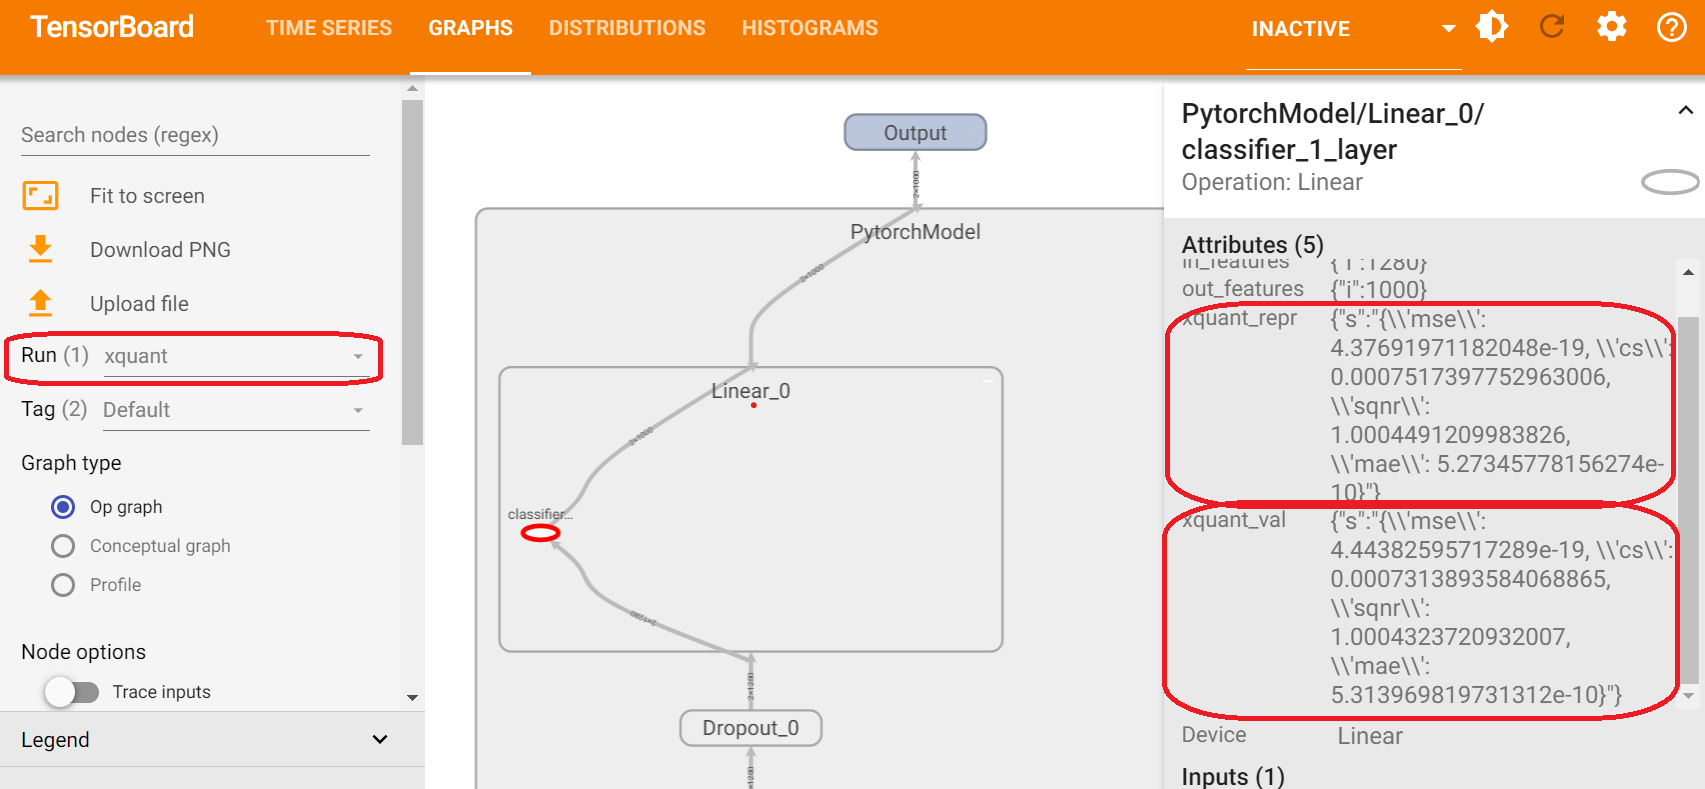

Now we can run TensorBoard:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs